In [1]:
import sys
import warnings
sys.path.insert(0, '/data16/marcus/scripts/nanoporePipelineScripts')
import nanoporePipelineCommon as npCommon

from tqdm.notebook import tqdm

import seaborn as sea
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "browser"

import numpy as np
import pandas as pd
import statistics as stats
pd.set_option('display.width', 200)
pd.set_option('display.max_columns', None)

CONVERSION_DICT = {"xrn-1-5tera": "oldN2",
                   "xrn-1-5tera-smg-6": "oldS6",
                   "5tera_xrn-1-KD_wt": "newN2",
                   "5tera_xrn-1-KD_smg-5": "newS5",
                   "5tera_xrn-1-KD_smg-6": "newS6",
                   "5tera_xrn-1-KD_smg-7": "newS7",
                   "5tera_xrn-1-KD_wt_rerun": "newerN2",
                   "5tera_xrn-1-KD_smg-6_rerun": "newerS6",
                   "sPM57": "sPM57",
                   "sPM58": "sPM58",
                   }
REV_CONVERSION_DICT = {val: key for key, val in CONVERSION_DICT.items()}

print(f"Imports done at {npCommon.get_dt(for_print=True)}")

Imports done at 04/03/23 @ 05:51:12 PM


# Load pre-processed files:

In [5]:
regenerate = False
libs_to_load = sorted({
    'oldN2',
    'newN2',
    'newerN2',
    'oldS6',
    'newS6',
    'newerS6',
    # 'newS5',
    # 'newerS5',
    # 'newS7',
})

try:
    if regenerate:
        raise ValueError
    
    reads_df_raw_path = npCommon.find_newest_matching_file(f"./output_files/mega_merge_parquets/*_{'-'.join(libs_to_load)}_merged5TERA.reads_df.parquet")
    compressed_df_genes_raw_path = npCommon.find_newest_matching_file(f"./output_files/mega_merge_parquets/*_{'-'.join(libs_to_load)}_merged5TERA.compressed_df.parquet")
    print(f"Found preprocessed files at:\n\t{reads_df_raw_path}\nand:\n\t{compressed_df_genes_raw_path}")

    reads_df_genes_raw = pd.read_parquet(reads_df_raw_path)
    compressed_df_genes_raw = pd.read_parquet(compressed_df_genes_raw_path)
except ValueError:
    print(f"Could not find preprocessed files matching these libs: {'/'.join(libs_to_load)}\nGoing to create new ones from scratch! This will take longer.")
    reads_df_genes_raw, compressed_df_genes_raw = npCommon.load_and_merge_lib_parquets([REV_CONVERSION_DICT[lib] for lib in libs_to_load],
                                                                                       drop_sub_n=1,
                                                                                       add_tail_groupings=False,
                                                                                       drop_failed_polya=False,
                                                                                       group_by_t5=True,
                                                                                       use_josh_assignment=False)
    print(f"Saving new parquets to speed up future runs.")
    reads_df_genes_raw.to_parquet(f"./output_files/mega_merge_parquets/{npCommon.get_dt()}_{'-'.join(libs_to_load)}_merged5TERA.reads_df.parquet")
    compressed_df_genes_raw.to_parquet(f"./output_files/mega_merge_parquets/{npCommon.get_dt()}_{'-'.join(libs_to_load)}_merged5TERA.compressed_df.parquet")
print(f"Lib load done @ {npCommon.get_dt(for_print=True)}")

compressed_df_genes_short = compressed_df_genes_raw.copy()[["lib", "chr_id", "gene_id", "gene_name", "t5", "gene_hits", "gene_rpm"]]
compressed_df_genes_short.query("gene_name == 'rpl-12'")

Found preprocessed files at:
	./output_files/mega_merge_parquets/230403_newN2-newS6-newerN2-newerS6-oldN2-oldS6_merged5TERA.reads_df.parquet
and:
	./output_files/mega_merge_parquets/230403_newN2-newS6-newerN2-newerS6-oldN2-oldS6_merged5TERA.compressed_df.parquet
Lib load done @ 04/03/23 @ 05:55:44 PM


,lib,chr_id,gene_id,gene_name,t5,gene_hits,gene_rpm
4278,5tera_xrn-1-KD_smg-6,IV,WBGene00004424,rpl-12,-,435,6386.914900
4279,5tera_xrn-1-KD_smg-6,IV,WBGene00004424,rpl-12,+,6,88.095378
17486,5tera_xrn-1-KD_smg-6_rerun,IV,WBGene00004424,rpl-12,-,5440,7276.861853
17487,5tera_xrn-1-KD_smg-6_rerun,IV,WBGene00004424,rpl-12,+,53,70.895897
31241,5tera_xrn-1-KD_wt,IV,WBGene00004424,rpl-12,-,453,4157.031164
31242,5tera_xrn-1-KD_wt,IV,WBGene00004424,rpl-12,+,10,91.766692
44390,5tera_xrn-1-KD_wt_rerun,IV,WBGene00004424,rpl-12,-,1739,3489.550412
44391,5tera_xrn-1-KD_wt_rerun,IV,WBGene00004424,rpl-12,+,36,72.239111
61672,xrn-1-5tera,IV,WBGene00004424,rpl-12,-,1829,3207.443935
61673,xrn-1-5tera,IV,WBGene00004424,rpl-12,+,52,91.190314


# Format libraries as columns with shortened names

In [3]:
conversion_dict = CONVERSION_DICT
ans = [y for x, y in compressed_df_genes_short.groupby(['lib', 't5'], as_index=False)]
df_dict = {}
for i, df in enumerate(ans):
    lib = df.lib.unique()[0]
    t5 = df.t5.unique()[0]
    df = df[["chr_id", "gene_id", "gene_name", "gene_hits", "gene_rpm"]]
    df = df.rename(columns={col: f'{col}_{conversion_dict[lib]}_t5{t5}' for col in df.columns if col not in ["chr_id", "gene_id", "gene_name"]})
    df_dict[(conversion_dict[lib], t5)] = df.set_index(["chr_id", "gene_id", "gene_name"])
    # print((conversion_dict[lib], t5))
    # print(df_dict[(conversion_dict[lib], t5)].query("gene_name == 'rpl-12'"))

super_df = pd.concat(df_dict.values(), axis=1, join='outer').fillna(0)
super_df

gene_hits_newS6_t5+  gene_rpm_newS6_t5+  gene_hits_newS6_t5-  gene_rpm_newS6_t5-  gene_hits_newerS6_t5+  gene_rpm_newerS6_t5+  gene_hits_newerS6_t5-  \
chr_id gene_id        gene_name                                                                                                                                                         
I      WBGene00000165 aps-3                      2.0           29.365126                 14.0          205.555882                    0.0              0.000000                   41.0   
       WBGene00000230 atp-3                      2.0           29.365126                 82.0         1203.970165                   12.0             16.051901                  871.0   
       WBGene00000473 cey-2                      1.0           14.682563                  7.0          102.777941                    1.0              1.337658                  135.0   
       WBGene00000634 col-58                     1.0           14.682563                  7.0          102.777941                    2.0              2.675317                   36.0   
       WBGene00000869 cyc-1                      1.0           14.682563                  5.0           73.412815                    0.0              0.000000                   99.0   
...                                              ...                 ...                  ...                 ...                    ...                   ...                    ...   
X      WBGene00197761 C18A11.10                  0.0            0.000000                  0.0            0.000000                    0.0              0.000000                    0.0   
       WBGene00199316 PDB1.2                     0.0            0.000000                  0.0            0.000000                    0.0              0.000000                    0.0   
       WBGene00206484 C31H2.14                   0.0            0.000000                  0.0            0.000000                    0.0              0.000000                    0.0   
       WBGene00220051 R160.11                    0.0            0.000000                  0.0            0.000000                    0.0              0.000000                    0.0   
       WBGene00235152 Y7A5A.22                   0.0            0.000000                  0.0            0.000000                    0.0              0.000000                    0.0   

                                 gene_rpm_newerS6_t5-  gene_hits_newN2_t5+  gene_rpm_newN2_t5+  gene_hits_newN2_t5-  gene_rpm_newN2_t5-  gene_hits_newerN2_t5+  gene_rpm_newerN2_t5+  \
chr_id gene_id        gene_name                                                                                                                                                        
I      WBGene00000165 aps-3                 54.843996                  0.0            0.000000                 24.0          220.240062                    0.0              0.000000   
       WBGene00000230 atp-3               1165.100492                  0.0            0.000000                 94.0          862.606908                    2.0              4.013284   
       WBGene00000473 cey-2                180.583888                  1.0            9.176669                 66.0          605.660170                    2.0              4.013284   
       WBGene00000634 col-58                48.155703                  2.0           18.353338                  8.0           73.413354                    4.0              8.026568   
       WBGene00000869 cyc-1                132.428184                  0.0            0.000000                 15.0          137.650039                    2.0              4.013284   
...                                               ...                  ...                 ...                  ...                 ...                    ...                   ...   
X      WBGene00197761 C18A11.10              0.000000                  0.0            0.000000                  0.0            0.000000                    

In [7]:
# This step will calculate total hits and the fraction adapted for each gene, then apply a filter for a minimum number of gene hits, adapted hits or unadapted hits

# This is currently a little problematic because it will filter all libraries based on the worst preforming library!

filter_df = pd.DataFrame()
for lib in libs_to_load:
    for rpm_or_hits in ["rpm", "hits"]:
        super_df[f"total_gene_{rpm_or_hits}_{lib}"] = super_df[f"gene_{rpm_or_hits}_{lib}_t5+"] + super_df[f"gene_{rpm_or_hits}_{lib}_t5-"]
    super_df[f"fraction_adapted_{lib}"] = super_df[f"gene_hits_{lib}_t5+"] / super_df[f"total_gene_hits_{lib}"]
    
    cols_to_carry_over = [col for col in super_df.columns if lib in col]
    filter_df[cols_to_carry_over] = super_df[cols_to_carry_over]
filter_df

gene_hits_newN2_t5+  gene_rpm_newN2_t5+  gene_hits_newN2_t5-  gene_rpm_newN2_t5-  total_gene_rpm_newN2  total_gene_hits_newN2  fraction_adapted_newN2  \
chr_id gene_id        gene_name                                                                                                                                                          
I      WBGene00000165 aps-3                      0.0            0.000000                 24.0          220.240062            220.240062                   24.0                0.000000   
       WBGene00000230 atp-3                      0.0            0.000000                 94.0          862.606908            862.606908                   94.0                0.000000   
       WBGene00000473 cey-2                      1.0            9.176669                 66.0          605.660170            614.836839                   67.0                0.014925   
       WBGene00000634 col-58                     2.0           18.353338                  8.0           73.413354             91.766692                   10.0                0.200000   
       WBGene00000869 cyc-1                      0.0            0.000000                 15.0          137.650039            137.650039                   15.0                0.000000   
...                                              ...                 ...                  ...                 ...                   ...                    ...                     ...   
X      WBGene00197761 C18A11.10                  0.0            0.000000                  0.0            0.000000              0.000000                    0.0                     NaN   
       WBGene00199316 PDB1.2                     0.0            0.000000                  0.0            0.000000              0.000000                    0.0                     NaN   
       WBGene00206484 C31H2.14                   0.0            0.000000                  0.0            0.000000              0.000000                    0.0                     NaN   
       WBGene00220051 R160.11                    0.0            0.000000                  0.0            0.000000              0.000000                    0.0                     NaN   
       WBGene00235152 Y7A5A.22                   0.0            0.000000                  0.0            0.000000              0.000000                    0.0                     NaN   

                                 gene_hits_newS6_t5+  gene_rpm_newS6_t5+  gene_hits_newS6_t5-  gene_rpm_newS6_t5-  total_gene_rpm_newS6  total_gene_hits_newS6  fraction_adapted_newS6  \
chr_id gene_id        gene_name                                                                                                                                                          
I      WBGene00000165 aps-3                      2.0           29.365126                 14.0          205.555882            234.921008                   16.0                0.125000   
       WBGene00000230 atp-3                      2.0           29.365126                 82.0         1203.970165           1233.335291                   84.0                0.023810   
       WBGene00000473 cey-2                      1.0           14.682563                  7.0          102.777941            117.460504                    8.0                0.125000   
       WBGene00000634 col-58                     1.0           14.682563                  7.0          102.777941            117.460504                    8.0                0.125000   
       WBGene00000869 cyc-1                      1.0           14.682563                  5.0           73.412815             88.095378                    6.0                0.166667   
...                                              ...                 ...                  ...                 ...                   ...                    ...                     ...   
X      WBGene00197761 C18A11.10                  0.0            0.000000                  0.0            0.000000             

In [8]:
from scipy.stats import chi2_contingency, chisquare, fisher_exact, boschloo_exact, barnard_exact
def row_chi2(row, target_lib_1, target_lib_2):
    array = np.array([[row[f"gene_hits_{target_lib_1}_t5-"], row[f"gene_hits_{target_lib_2}_t5-"]],
                      [row[f"gene_hits_{target_lib_1}_t5+"], row[f"gene_hits_{target_lib_2}_t5+"]]])
    try:
        chi2, p, deg_of_free, expected = chi2_contingency(array)
        return chi2, p
    except ValueError:
        return None, None

def row_fishers_exact(row, target_lib_1, target_lib_2, hits_or_rpm='hits', alternative='two-sided'):
    array = np.array([[row[f"gene_{hits_or_rpm}_{target_lib_1}_t5-"], row[f"gene_{hits_or_rpm}_{target_lib_2}_t5-"]],
                      [row[f"gene_{hits_or_rpm}_{target_lib_1}_t5+"], row[f"gene_{hits_or_rpm}_{target_lib_2}_t5+"]]])
    if alternative not in ['two-sided', 'greater', 'less']:
        raise KeyError(f"Please use 'two-sided', 'greater', or 'less' for the alternative hypothesis input for fisher's exact test!!")
    odds_ratio, p_value = fisher_exact(array, alternative=alternative)
    return odds_ratio, p_value

def row_boschloo_exact(row, target_lib_1, target_lib_2, hits_or_rpm='hits', alternative='two-sided', sampling_points=32):
    array = np.array([[row[f"gene_{hits_or_rpm}_{target_lib_1}_t5-"], row[f"gene_{hits_or_rpm}_{target_lib_2}_t5-"]],
                      [row[f"gene_{hits_or_rpm}_{target_lib_1}_t5+"], row[f"gene_{hits_or_rpm}_{target_lib_2}_t5+"]]])
    if alternative not in ['two-sided', 'greater', 'less']:
        raise KeyError(f"Please use 'two-sided', 'greater', or 'less' for the alternative hypothesis input for Boschloo's exact test!!")
    boschloo_result = boschloo_exact(array, alternative=alternative, n=sampling_points)
    return boschloo_result.statistic, boschloo_result.pvalue

def row_barnard_exact(row, target_lib_1, target_lib_2, hits_or_rpm='hits', alternative='two-sided', sampling_points=32):
    array = np.array([[row[f"gene_{hits_or_rpm}_{target_lib_1}_t5-"], row[f"gene_{hits_or_rpm}_{target_lib_2}_t5-"]],
                      [row[f"gene_{hits_or_rpm}_{target_lib_1}_t5+"], row[f"gene_{hits_or_rpm}_{target_lib_2}_t5+"]]])
    if alternative not in ['two-sided', 'greater', 'less']:
        raise KeyError(f"Please use 'two-sided', 'greater', or 'less' for the alternative hypothesis input for Barnard's exact test!!")
    barnard_result = barnard_exact(array, alternative=alternative, n=sampling_points)
    return barnard_result.statistic, barnard_result.pvalue

In [9]:
# p-value setpoint and the applied cutoffs will be used for a Bonferroni correction
#   Currently no genes will be dropped based on these filters/cutoffs
base_sig_cutoff = 0.05

cumulative_min_read_cutoff = 100
filter_with_rpm_or_hits = "hits"
filter_col_target = "unadapted"  # "total" or "adapted" or "unadapted"

p_value_cutoff_dict = {}

lib_comparisons_to_test = []
# lib_comparisons_to_test += list(zip(["newN2"]*3, ["newS5", "newS6", "newS7"]))
lib_comparisons_to_test += [("newN2", "newS6")]
lib_comparisons_to_test += [("oldN2", "oldS6")]
lib_comparisons_to_test += [("newerN2", "newerS6")]
# lib_comparisons_to_test += [("sPM57", "sPM58")]

for libs in lib_comparisons_to_test:
    first_lib, second_lib = libs
    with warnings.catch_warnings():
        tqdm.pandas(desc=f"Calculating Chi Squared for {first_lib} and {second_lib}")
        filter_df[[f"{first_lib}_v_{second_lib}_chi2_test_result", f"{first_lib}_v_{second_lib}_chi2_p_value"]] = filter_df.progress_apply(lambda row: row_chi2(row, first_lib, second_lib), axis=1, result_type="expand")
        
        tqdm.pandas(desc=f"Calculating Fisher's exact for {first_lib} and {second_lib}")
        filter_df[[f"{first_lib}_v_{second_lib}_fishers_test_result", f"{first_lib}_v_{second_lib}_fishers_p_value"]] = filter_df.progress_apply(lambda row: row_fishers_exact(row, first_lib, second_lib, hits_or_rpm='hits', alternative='less'), axis=1, result_type="expand")
        
        # Barnard's and Boschloo tests take forever!!
        # tqdm.pandas(desc=f"Calculating Boschloo exact for {first_lib} and {second_lib}")
        # filter_df[[f"{first_lib}_v_{second_lib}_boschloo_test_result", f"{first_lib}_v_{second_lib}_boschloo_p_value"]] = filter_df.progress_apply(lambda row: row_boschloo_exact(row, first_lib, second_lib, hits_or_rpm='hits', alternative='less', sampling_points=4), axis=1, result_type="expand")
    
    for stat_test in ['chi2',
                      # 'barnard',
                      'boschloo',
                      'fishers',
                      ]:
        lib_cols_for_correction = []
        for lib in libs:
            filter_col_converter = {"total": f"total_gene_{filter_with_rpm_or_hits}_{lib}",
                                    "adapted": f"gene_{filter_with_rpm_or_hits}_{lib}_t5+",
                                    "unadapted": f"gene_{filter_with_rpm_or_hits}_{lib}_t5-"}
            lib_cols_for_correction.append(filter_col_converter[filter_col_target])
        cumulative_col_name = f"cumulative_{filter_col_target}_{filter_with_rpm_or_hits}_{first_lib}_{second_lib}"
        filter_df[cumulative_col_name] = filter_df[lib_cols_for_correction[0]] + filter_df[lib_cols_for_correction[1]]
        number_of_genes_passing_cutoff = filter_df[filter_df[cumulative_col_name] >= cumulative_min_read_cutoff].shape[0]
        adjusted_sig_cutoff = base_sig_cutoff / number_of_genes_passing_cutoff
        p_value_cutoff_dict[(libs, stat_test)] = (adjusted_sig_cutoff, number_of_genes_passing_cutoff)
        print(f"There were {number_of_genes_passing_cutoff} genes that passed the cutoff of having >={cumulative_min_read_cutoff} cumulative {filter_col_target} {filter_with_rpm_or_hits} between {first_lib} and {second_lib}"
              f"\n\tA Bonferroni correction with this in mind will expect a p value of {adjusted_sig_cutoff:.3g} for a significant {stat_test} test result.")
        try:
            filter_df.sort_values(f"{first_lib}_v_{second_lib}_{stat_test}_p_value")
            filter_df[f"neg_log10_{first_lib}_v_{second_lib}_{stat_test}_p_value"] = -np.log10(filter_df[f"{first_lib}_v_{second_lib}_{stat_test}_p_value"])
            filter_df[f"{first_lib}_v_{second_lib}_{stat_test}_significant"] = filter_df[f"{first_lib}_v_{second_lib}_{stat_test}_p_value"] <= adjusted_sig_cutoff
        except KeyError:
            print(f"Couldn't find columns corresponding to '{stat_test}'!! Be sure spelling is correct!")
print('done.')

Calculating Chi Squared for newN2 and newS6:   0%|          | 0/15768 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/scipy/stats/contingency.py:134: RuntimeWarning:

invalid value encountered in divide



Calculating Fisher's exact for newN2 and newS6:   0%|          | 0/15768 [00:00<?, ?it/s]

There were 261 genes that passed the cutoff of having >=100 cumulative unadapted hits between newN2 and newS6
	A Bonferroni correction with this in mind will expect a p value of 0.000192 for a significant chi2 test result.
There were 261 genes that passed the cutoff of having >=100 cumulative unadapted hits between newN2 and newS6
	A Bonferroni correction with this in mind will expect a p value of 0.000192 for a significant boschloo test result.
Couldn't find columns corresponding to 'boschloo'!! Be sure spelling is correct!
There were 261 genes that passed the cutoff of having >=100 cumulative unadapted hits between newN2 and newS6
	A Bonferroni correction with this in mind will expect a p value of 0.000192 for a significant fishers test result.


Calculating Chi Squared for oldN2 and oldS6:   0%|          | 0/15768 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/scipy/stats/contingency.py:134: RuntimeWarning:

invalid value encountered in divide



Calculating Fisher's exact for oldN2 and oldS6:   0%|          | 0/15768 [00:00<?, ?it/s]

There were 991 genes that passed the cutoff of having >=100 cumulative unadapted hits between oldN2 and oldS6
	A Bonferroni correction with this in mind will expect a p value of 5.05e-05 for a significant chi2 test result.
There were 991 genes that passed the cutoff of having >=100 cumulative unadapted hits between oldN2 and oldS6
	A Bonferroni correction with this in mind will expect a p value of 5.05e-05 for a significant boschloo test result.
Couldn't find columns corresponding to 'boschloo'!! Be sure spelling is correct!
There were 991 genes that passed the cutoff of having >=100 cumulative unadapted hits between oldN2 and oldS6
	A Bonferroni correction with this in mind will expect a p value of 5.05e-05 for a significant fishers test result.


Calculating Chi Squared for newerN2 and newerS6:   0%|          | 0/15768 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/scipy/stats/contingency.py:134: RuntimeWarning:

invalid value encountered in divide



Calculating Fisher's exact for newerN2 and newerS6:   0%|          | 0/15768 [00:00<?, ?it/s]

There were 1491 genes that passed the cutoff of having >=100 cumulative unadapted hits between newerN2 and newerS6
	A Bonferroni correction with this in mind will expect a p value of 3.35e-05 for a significant chi2 test result.
There were 1491 genes that passed the cutoff of having >=100 cumulative unadapted hits between newerN2 and newerS6
	A Bonferroni correction with this in mind will expect a p value of 3.35e-05 for a significant boschloo test result.
Couldn't find columns corresponding to 'boschloo'!! Be sure spelling is correct!
There were 1491 genes that passed the cutoff of having >=100 cumulative unadapted hits between newerN2 and newerS6
	A Bonferroni correction with this in mind will expect a p value of 3.35e-05 for a significant fishers test result.
done.


# Look at the top "most significant" hits

In [10]:
how_many_hits_to_save = 100
for stat_test in ["chi2", "fishers"]:
    for first_lib, second_lib in lib_comparisons_to_test:
        temp_df = filter_df[[f"gene_rpm_{first_lib}_t5-",
                            f"gene_rpm_{first_lib}_t5+",
                            f"gene_rpm_{second_lib}_t5-",
                            f"gene_rpm_{second_lib}_t5+",
                            f"{first_lib}_v_{second_lib}_{stat_test}_test_result",
                            f"{first_lib}_v_{second_lib}_{stat_test}_p_value",
                            f"{first_lib}_v_{second_lib}_{stat_test}_significant",
                            ]].sort_values(f"{first_lib}_v_{second_lib}_{stat_test}_p_value",
                                           ascending=True).head(how_many_hits_to_save)
        print(temp_df)
        # temp_df.to_csv(f"./output_files/{npCommon.get_dt()}_{first_lib}_v_{second_lib}.{stat_test}.top{how_many_hits_to_save}.csv")

                                 gene_rpm_newN2_t5-  gene_rpm_newN2_t5+  gene_rpm_newS6_t5-  gene_rpm_newS6_t5+  newN2_v_newS6_chi2_test_result  newN2_v_newS6_chi2_p_value  \
chr_id gene_id        gene_name                                                                                                                                               
V      WBGene00008944 F19B2.5            266.123408          110.120031         1203.970165           44.047689                       15.103779                    0.000102   
X      WBGene00022951 C30E1.9            183.533385           45.883346         1218.652728            0.000000                       13.170820                    0.000284   
V      WBGene00012680 Y39B6A.21           64.236685           45.883346          469.842016           14.682563                        8.270323                    0.004030   
X      WBGene00016662 C45B2.8             55.060015           27.530008          616.667646           14.682563              

In [11]:
# fig = px.scatter_matrix(filter_df.reset_index(),
#                         dimensions=[col for col in filter_df if "fraction_adapted" in col],
#                         labels={f"fraction_adapted_{lib}":f"Fraction Adapted <br> {lib}" for lib in conversion_dict.values()},
#                         hover_name="gene_name")
# fig.update_layout(template="plotly_white")
# # fig.update_layout(xaxis=dict(type='log'),xaxis2=dict(type='log'),xaxis3=dict(type='log'),xaxis4=dict(type='log'))
# fig.show()

/usr/local/lib/python3.8/dist-packages/plotly/express/_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



# Plot relationship of fraction adapted between "replicates"

In [11]:
libs_combos_to_plot = [("oldN2", "newN2")] + [("oldS6", "newS6")] + [("sPM57", "sPM58")]  #+ list(zip(["newN2"]*3, ["newS5", "newS6", "newS7"])) + [("oldN2", "oldS6")]

drop_zeros = False
log_plot = True

# WE"LL HAVE THESE THINGS CARRY OVER FROM ABOVE CELL!!
# min_read_cutoff = 100
# filter_with_rpm_or_hits = "hits"
# filter_col_target = "unadapted"  # "total" or "adapted" or "unadapted"

for libs_to_plot in libs_combos_to_plot:
    first_lib, second_lib = libs_to_plot
    plot_df = filter_df[[col for col in filter_df.columns if first_lib in col or second_lib in col]]
    # I have the filter step running again down here so that we can do it more stepwise!
    for lib in libs_to_plot:
        filter_col_converter = {"total": f"total_gene_{filter_with_rpm_or_hits}_{lib}",
                                "adapted": f"gene_{filter_with_rpm_or_hits}_{lib}_t5+",
                                "unadapted": f"gene_{filter_with_rpm_or_hits}_{lib}_t5-"}
        plot_df = plot_df[plot_df[filter_col_converter[filter_col_target]] >= cumulative_min_read_cutoff]
        if drop_zeros:
            # To have the OLS work with logged data we need all values to be positive:
            plot_df = plot_df.query(f"fraction_adapted_{lib} > 0")
    if drop_zeros:
        additional_plot_params = dict(trendline_options=dict(log_x=True, log_y=True))
        additional_title_details = " (All zero values dropped)"
        additional_file_details = ".droppedZeros"
    else:
        additional_plot_params = {}
        additional_title_details = ""
        additional_file_details = ""
    if log_plot:
        additional_plot_params = {**additional_plot_params, "log_x": True, "log_y": True}
    fig = px.scatter(plot_df.reset_index(),
                     x=f"fraction_adapted_{first_lib}",
                     y=f"fraction_adapted_{second_lib}",
                     # log_x=True, log_y=True,
                     hover_name="gene_name",
                     hover_data=[col for col in filter_df.columns if first_lib in col or second_lib in col],
                     trendline="ols",
                     labels={f"fraction_adapted_{lib}":f"Fraction Adapted <br> {lib}" for lib in conversion_dict.values()},
                     **additional_plot_params)
    
    print(first_lib, second_lib)
    results = px.get_trendline_results(fig).px_fit_results.iloc[0]
    print(results.summary())
    
    fig.update_layout(template="plotly_white", title=f"<b>Fraction Adapted for {first_lib} and {second_lib}</b><br>w/ {filter_with_rpm_or_hits} cutoff of {cumulative_min_read_cutoff} across plotted libs {'&nbsp;' * 5} OLS Trendline; R<sup>2</sup>: {results.rsquared:0.4f}; adjR<sup>2</sup>: {results.rsquared_adj:0.4f} {'&nbsp;' * 5} n={plot_df.shape[0]}{additional_title_details}")
    fig.write_html(f"./output_files/{npCommon.get_dt()}_fractionAdapted_{first_lib}-v-{second_lib}_min{cumulative_min_read_cutoff}{filter_col_target}{filter_with_rpm_or_hits.title()}{additional_file_details}.scatter.html")
    fig.show()

oldN2 newN2
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     551.0
Date:                Tue, 21 Mar 2023   Prob (F-statistic):           3.70e-54
Time:                        11:57:13   Log-Likelihood:                 445.59
No. Observations:                 165   AIC:                            -887.2
Df Residuals:                     163   BIC:                            -881.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0011      0.001     -0.

# Plot to try and decide cutoff for total/adapted/unadapted hits/rpm

In [18]:
libs_combos_to_plot = [("oldN2", "newN2")] + [("oldS6", "newS6")] + [("newN2", "newS6")] + [("sPM57", "sPM58")] #+ list(zip(["newN2"]*3, ["newS5", "newS6", "newS7"])) + [("oldN2", "oldS6")]
plot_with_rpm_or_hits = "hits"
plot_col_target = "unadapted"  # "total" or "adapted" or "unadapted"

def calc_stdDev_and_stdDevOverMean(values):
    std_dev = stats.stdev(values)
    mean = stats.mean(values)
    try:
        std_dev_over_mean = std_dev / mean
    except ZeroDivisionError:
        std_dev_over_mean = np.Inf
    return std_dev, mean, std_dev_over_mean

for libs_to_plot in libs_combos_to_plot:
    first_lib, second_lib = libs_to_plot
    plot_df = filter_df[[col for col in filter_df.columns if first_lib in col or second_lib in col]]
    plot_cols = []
    for lib in libs_to_plot:
        plot_col_converter = {"total": f"total_gene_{plot_with_rpm_or_hits}_{lib}",
                              "adapted": f"gene_{plot_with_rpm_or_hits}_{lib}_t5+",
                              "unadapted": f"gene_{plot_with_rpm_or_hits}_{lib}_t5-"}
        plot_cols.append(plot_col_converter[plot_col_target])
    metric_col_name = f"combined_{plot_col_target}_{plot_with_rpm_or_hits}_{first_lib}+{second_lib}"
    plot_df[metric_col_name] = plot_df[plot_cols[0]] + plot_df[plot_cols[1]]
    
    plot_df[f"fracAdapted_{first_lib}/{second_lib}"] = (plot_df[f"fraction_adapted_{first_lib}"] / plot_df[f"fraction_adapted_{second_lib}"])
    plot_df[f"log2_fracAdapted_{first_lib}/{second_lib}"] = np.log2(plot_df[f"fracAdapted_{first_lib}/{second_lib}"])
    
    plot_df[f"deltaFracAdapted_{first_lib}-{second_lib}"] = (plot_df[f"fraction_adapted_{first_lib}"] - plot_df[f"fraction_adapted_{second_lib}"])
    
    plot_df[f"fracAdapted_FC_{first_lib}/{second_lib}"] = np.log2((plot_df[f"fraction_adapted_{first_lib}"] / plot_df[f"fraction_adapted_{second_lib}"]))
    
    plot_df[[f"stdDev_fracAdapted_{first_lib}_{second_lib}", f"mean_fracAdapted_{first_lib}_{second_lib}", f"stdDevOverMean_fracAdapted_{first_lib}_{second_lib}"]] = plot_df.apply(lambda row: calc_stdDev_and_stdDevOverMean([row[f"fraction_adapted_{first_lib}"], row[f"fraction_adapted_{second_lib}"]]), axis=1, result_type="expand")
    
    fig = px.scatter(plot_df.reset_index(),
                     x=metric_col_name,
                     # =f"mean_fracAdapted_{first_lib}_{second_lib}",
                     # y=f"stdDev_fracAdapted_{first_lib}_{second_lib}",
                     y=f"deltaFracAdapted_{first_lib}-{second_lib}",
                     color="chr_id",
                     log_x=True,
                     hover_name="gene_name",
                     hover_data=["gene_id", "chr_id"] + [col for col in filter_df.columns if first_lib in col or second_lib in col])
    
    fig.update_layout(template="plotly_white")
    fig.write_html(f"./output_files/{npCommon.get_dt()}_deltaFracAdapted-v-combined{plot_col_target.title()}{plot_with_rpm_or_hits.title()}_{first_lib}-{second_lib}.scatter.html")
    fig.write_image(f"./output_files/{npCommon.get_dt()}_deltaFracAdapted-v-combined{plot_col_target.title()}{plot_with_rpm_or_hits.title()}_{first_lib}-{second_lib}.scatter.png")
    fig.show()
    print(plot_df.shape)

/tmp/ipykernel_182687/236335307.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_182687/236335307.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning:

divide by zero encountered in log2

/tmp/ipykernel_182687/236335307.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

(15604, 58)


/tmp/ipykernel_182687/236335307.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_182687/236335307.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning:

divide by zero encountered in log2

/tmp/ipykernel_182687/236335307.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

(15604, 40)


/tmp/ipykernel_182687/236335307.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_182687/236335307.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning:

divide by zero encountered in log2

/tmp/ipykernel_182687/236335307.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

(15604, 49)


/tmp/ipykernel_182687/236335307.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_182687/236335307.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning:

divide by zero encountered in log2

/tmp/ipykernel_182687/236335307.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

(15604, 31)


# Plot fraction adapted fold change and Chi2/Fishers p-values

In [63]:
from plotly.subplots import make_subplots

round_inf_to = 7

lib_comparisons_to_plot = [
    # ("newN2", "newS5"),
    # ("newN2", "newS6"),
    # ("newN2", "newS7"),
    ("oldN2", "oldS6"),
    # ("sPM57", "sPM58"),
    ("newerN2", "newerS6"),
]

stat_test = "fishers"  # "fishers" or "chi2"

plot_df = filter_df.copy(deep=True)
for first_lib, second_lib in lib_comparisons_to_plot:
    plot_df[f"fracAdapted_FC_{first_lib}/{second_lib}"] = np.log2(plot_df[f"fraction_adapted_{first_lib}"] / plot_df[f"fraction_adapted_{second_lib}"])
plot_df = plot_df.reset_index()
plot_df = plot_df[plot_df.chr_id != 'MtDNA']
plot_df = plot_df.replace({-np.inf: -round_inf_to, np.inf: round_inf_to})


fig = make_subplots(rows=1, cols=len(lib_comparisons_to_plot),
                    shared_yaxes=True,
                    shared_xaxes=True,
                    vertical_spacing=0.02,
                    horizontal_spacing=0.02,
                    subplot_titles=[f"{libs[0]} vs {libs[1]}" for libs in lib_comparisons_to_plot],
                    )

for i, (first_lib, second_lib) in enumerate(lib_comparisons_to_plot):
    print(first_lib, second_lib)
    fig.add_trace(go.Scatter(
        x=plot_df[f"fracAdapted_FC_{first_lib}/{second_lib}"],
        y=plot_df[f"neg_log10_{first_lib}_v_{second_lib}_{stat_test}_p_value"],
        marker_color=plot_df[f"{first_lib}_v_{second_lib}_{stat_test}_significant"].replace({False: "black", True: "red"}),
        hovertext=plot_df["gene_name"],
        mode="markers",
        name=f"{second_lib}"),
                  row=1, col=i+1)
    
    cutoff, num_passed_genes = p_value_cutoff_dict[((first_lib, second_lib), "fishers")]
    fig.add_hline(y=-np.log10(cutoff),
              row=1, col=i+1)
    fig.add_annotation(text=f"Bonferroni<br>p-value = {cutoff:0.3e}",
                       yref="y",
                       y=-np.log10(cutoff),
                       xref="x domain",
                       x=0,
                       yanchor="bottom",
                       showarrow=False,
                       align="left",
                       row=1, col=i+1)
    fig.add_annotation(text=f"<b>genes w/ > 100 {filter_col_target} {filter_with_rpm_or_hits} = {num_passed_genes}",
                   yref="y domain",
                   y=0,
                   xref="x domain",
                   x=0.5,
                   yanchor="bottom",
                   showarrow=False,
                   align="center",
                   row=1, col=i+1)



fig.update_layout(template="plotly_white",
                  title=f"<b>FC Frac. Adapted vs. {stat_test.title()} Test P-Values</b>"
                        f"<br>Cumulative {filter_col_target} {filter_with_rpm_or_hits} for Cutoff = {cumulative_min_read_cutoff}")

fig.update_xaxes(tickvals=[f"-{round_inf_to}", "-4", "-2", "0", "2", "4", f"{round_inf_to}"],
                 ticktext=["-INF", "-4", "-2", "0", "2", "4", "INF"])

fig.update_yaxes(title_text=f"-log<sub>10</sub> {stat_test.title()} Test P-Value",
                 row=1, col=1)
fig.update_xaxes(title_text="Fold Change Fraction Adapted<br>N2 vs. smg")
fig.write_html(f"./output_files/fishers_tests/{npCommon.get_dt()}_{stat_test}Pvalues-v-FCfractionAdapted.scatters.html")
fig.show()
plot_df.query("gene_name == 'F19B2.5'").T

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning:

divide by zero encountered in log2

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning:

divide by zero encountered in log2



oldN2 oldS6
newerN2 newerS6


,447
chr_id,V
gene_id,WBGene00008944
gene_name,F19B2.5
gene_hits_newN2_t5+,12.0
gene_rpm_newN2_t5+,110.120031
...,...
newerN2_v_newerS6_chi2_significant,True
neg_log10_newerN2_v_newerS6_fishers_p_value,18.810005
newerN2_v_newerS6_fishers_significant,True
fracAdapted_FC_oldN2/oldS6,4.87721


# Looking at reproducibility
## April 3, 2023

,oldN2_v_oldS6_fishers_significant,newerN2_v_newerS6_fishers_significant,gene_name
25,False,True,rpl-1
32,True,True,rpl-30
38,False,True,smd-1
78,True,True,C53H9.2
155,True,False,xrn-1
176,False,True,farl-11
220,True,True,rpl-3
231,False,True,rps-22
234,True,True,ubl-1
319,True,True,rpl-7A


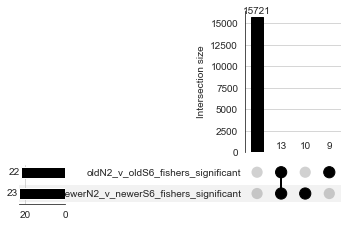

In [62]:
lib_comparisons_to_compare = [  # Try to just do two for now!
    # ("newN2", "newS5"),
    # ("newN2", "newS6"),
    # ("newN2", "newS7"),
    ("oldN2", "oldS6"),
    # ("sPM57", "sPM58"),
    ("newerN2", "newerS6"),
]
lib_comparisons_to_filter = [f"{libs[0]}_v_{libs[1]}" for libs in lib_comparisons_to_compare]
filter_cols = [col for col in plot_df.columns if any([filter_substring in col for filter_substring in lib_comparisons_to_filter]) or col in ['chr_id', 'gene_id', 'gene_name']]
filter_cols = [col for col in filter_cols if not "chi2" in col]
new_df = plot_df[filter_cols]
sea.set_style('white')

npCommon.boolDF_to_upsetPlot(new_df)
new_new_df = new_df.select_dtypes(include='bool')
new_new_df[new_new_df[new_new_df.columns[0]] + new_new_df[new_new_df.columns[1]]].merge(new_df['gene_name'], right_index=True, left_index=True)

# Assessing p-value rank "shape"

In [24]:
lib_comparisons_to_plot = [
    # ("newN2", "newS5"),
    # ("newN2", "newS6"),
    # ("newN2", "newS7"),
    ("oldN2", "oldS6"),
    # ("sPM57", "sPM58"),
    ("newerN2", "newerS6"),
]
plot_titles = list(zip([f"{libs[0]} vs {libs[1]}" for libs in lib_comparisons_to_plot], ["(zoom)"]*len(lib_comparisons_to_plot)))
print(sum(plot_titles, []))
fig = make_subplots(rows=len(lib_comparisons_to_plot), cols=2,
                    column_widths=[0.8, 0.2],
                    shared_yaxes=False,
                    shared_xaxes=True,
                    vertical_spacing=0.1,
                    horizontal_spacing=0.02,
                    subplot_titles=plot_titles)

for i, (lib1, lib2) in enumerate([("oldN2", "oldS6"),
                                  ("newN2", "newS5"),
                                  ("newN2", "newS6"),
                                  ("newN2", "newS7")]):
    plt_df = filter_df.sort_values(f"{lib1}_v_{lib2}_fishers_p_value").reset_index()
    p_values = plt_df[f'{lib1}_v_{lib2}_fishers_p_value']
    p_value_ranks = p_values.rank()
    non_1_max_p_value_rank = list(set(plt_df[f'{lib1}_v_{lib2}_fishers_p_value'].rank()))[-2]
    # ^ This value is similar to the number of p-values that I am "really testing"
    
    # Overall plots:
    fig.add_trace(go.Scatter(x=p_value_ranks,
                             y=p_values,
                             hovertext=plt_df['gene_name'],
                             mode="markers",
                             marker=dict(color="black"),
                             name=lib2),
                  row=i+1, col=1)
    
    # Add line for a FDR cutoff level using Benjamini-Hochberg method
    fig.add_trace(go.Scatter(y=[(0.05 / non_1_max_p_value_rank), 0.05],
                             x=[1, non_1_max_p_value_rank],
                             mode="lines",
                             marker=dict(color="red"),),
              row=i+1, col=1)
    
    # Zoom plots:
    fig.add_trace(go.Scatter(x=p_value_ranks,
                             y=p_values,
                             hovertext=plt_df['gene_name'],
                             mode="markers",
                             marker=dict(color="black"),
                             name=lib2),
                  row=i+1, col=2)
    fig.add_trace(go.Scatter(y=[(0.05 / non_1_max_p_value_rank), 0.05],
                             x=[1, non_1_max_p_value_rank],
                             mode="lines",
                             marker=dict(color="red"),),
              row=i+1, col=2)
    
    # Name axes:
    fig.update_yaxes(title_text=f"Fishers P-Value",
                     row=i+1, col=1)
    
    # Set zoom plot axis limits:
    fig.update_layout(**{f"yaxis{(i+1)*2}": dict(range=[0, 0.01]),
                         f"xaxis{(i+1)*2}": dict(range=[0, 25])})
fig.update_xaxes(title_text="Fishers P-Value Rank<br>N2 vs. smg",
                 row=4, col=1)
fig.update_xaxes(title_text="Fishers P-Value Rank<br>N2 vs. smg",
                 row=4, col=2)
fig.update_layout(title=f"Fishers P-value vs Ranking of Fishers P-value",
                  template="plotly_white",
                  showlegend=False)
fig.show()

TypeError: can only concatenate list (not "tuple") to list

In [15]:
rank_df = filter_df.copy(deep=True).reset_index()
rank_df = rank_df.query("chr_id != 'MtDNA'")

# This was over-engineered solution, all I really want to check is smg-6 replicable-ity and new smg-5 v new smg-6
lib_combos = [("oldN2", "oldS6"), ("newerN2", "newerS6"), ("newN2", "newS6")]
for i, libs1 in enumerate(lib_combos):
    libs2 = lib_combos[(i+1) % len(lib_combos)]
    # print(libs1, libs2)
    
    # but I can still use this loop for this step:
    lib1, lib2 = libs1
    rank_df[f"{lib1}_v_{lib2}_fishers_p_value_ranked"] = rank_df[f"{lib1}_v_{lib2}_fishers_p_value"].rank()

In [18]:
lib1, lib2, lib3, lib4 = 'newerN2', 'newerS6', 'oldN2', 'oldS6'

minimum_hits_for_both = 100
p_value_cutoff_for_both = 1

plot_rank_df = rank_df.query(f"cumulative_unadapted_hits_{lib1}_{lib2} > {minimum_hits_for_both}")\
                      .query(f"cumulative_unadapted_hits_{lib3}_{lib4} > {minimum_hits_for_both}")
plot_rank_df = plot_rank_df.query(f'{lib1}_v_{lib2}_fishers_p_value < {p_value_cutoff_for_both}')\
                           .query(f'{lib3}_v_{lib4}_fishers_p_value < {p_value_cutoff_for_both}')

fig = px.scatter(plot_rank_df,
                 x=f'{lib1}_v_{lib2}_fishers_p_value_ranked',
                 y=f'{lib3}_v_{lib4}_fishers_p_value_ranked',
                 hover_name='gene_name',
                 # hover_data=[''],
                 # log_x=True, log_y=True,
                 trendline='ols',
                 title=f"Comparison of ranked p_values for {lib1}_v_{lib2} and {lib3}_v_{lib4}"
                 )
fig.show()

fig = px.scatter(plot_rank_df,
                 x=f'{lib1}_v_{lib2}_fishers_p_value',
                 y=f'{lib3}_v_{lib4}_fishers_p_value',
                 hover_name='gene_name',
                 # hover_data=[''],
                 # log_x=True, log_y=True,
                 trendline='ols',
                 title=f"Comparison of p_values for {lib1}_v_{lib2} and {lib3}_v_{lib4}"
                 )
fig.show()

Plotting comparison of p-values has helped me appreciate that the majority of genes failed to be replicated between the libraries. Some genes of interest remain highly ranked in both of the library sets:
* F19B2.5   This is a fairly interesting little gene that only has 1 isoform. It obviously has some kind of NMD dependent cleavage or degradation event happening (the coverage plots in wildtype are slopes while they're pretty square in nmd knockouts)